In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import hermitenorm
from numba import njit
from math import factorial

In [37]:
@njit
def ode_hw(u, t, a=1):
    return -0.5 * u**2 + (a+1) * u

@njit
def ode_book(u,t, a=1):
    return -a*u

@njit
def fact(x):
    '''
    calculates factorial faster than scipy

    Arguments:
        x -- integer

    Returns:
        x!
    '''
    factors = np.arange(1,x+1)
    y = 1
    for i in range(x):
        y = y * factors[i]
    return y

# @njit
def e_ijk(i,j,k):
    s = (i+j+k) // 2
    if i+j+k == 2 * s and np.all(s >= np.array([i,j,k])):
        return (fact(i)*fact(j)*fact(k)) / (fact(s-i)*fact(s-j)*fact(s-k))
        #return (factorial(i)*factorial(j)*factorial(k)) / (factorial(s-i)*factorial(s-j)*factorial(s-k))
    else:
        return 0

@njit
def get_A(N, mu, sigma):
    A = np.zeros((N,N))
    a = np.array([mu, sigma])

    for k in range(N):
        for j in range(N):
            Ajk = 0
            for i, ai in enumerate(a):
                Ajk += ai * e_ijk(i,j,k)
            A[j,k] = -1/fact(k) * Ajk
    
    return A

# @njit
def get_A_book(N, mu, sigma):
    A = np.zeros((N,N))
    a = np.array([mu, sigma])

    for j in range(N):
        for k in range(N):
            Ajk = 0
            for i, ai in enumerate(a):
                Ajk += ai * e_ijk(i,j,k)
            A[j,k] = -1/fact(k) * Ajk
    return A

@njit
def get_b_book(N, betha):
    b = np.zeros(N)
    b[0] = betha
    return b

@njit
def get_vhats_book(N, mu, sigma, betha):
    A = get_A_book(N,mu,sigma)
    b = get_b_book(N,betha)
    vhats = np.linalg.solve(A.T,b)

    return vhats

def approx_book(t, vhats):
    u = 0
    for i, vhat in enumerate(vhats):
        u += vhat * hermitenorm(i)(t)
    return u

def euler_step_book(v,A,dt):
    return v + dt * np.dot(A.T,v)

@njit
def euler_step_ode_book(u,a,dt):
    return u + dt * ode_book(u, 0, a)

@njit
def euler_int_book(u0,steps,dt):
    ut = np.zeros(steps+1)

    a = np.random.normal(0,1)
    ut[0] = u0
    for i in range(steps):
        ut[i+1] = ut[i] +  dt * ode_book(ut[i], 0, a)
    return ut


In [38]:
x = 20
factorial(x) == fact(x)

True

In [39]:
print(fact(x))
print(factorial(x))

2432902008176640000
2432902008176640000


In [40]:
dt =  0.001
u0 = 0.1
steps = 3000
ut = euler_int_book(u0,steps,dt)


In [41]:
N = 100000
u2s = np.zeros(N)
for i in range(N):
    u2s[i] = euler_int_book(u0,steps,dt)[-1]

In [42]:
u0 = 0.1 # initial condition
mu = 0
sigma = 1
deg = 2+1

In [43]:
get_A_book(deg, mu, sigma)

array([[-0., -1., -0.],
       [-1., -0., -1.],
       [-0., -2., -0.]])

In [44]:
get_b_book(deg,u0)

array([0.1, 0. , 0. ])

In [45]:
e_ijk(4,1,1)

0

In [46]:
sol = np.zeros(steps+1)
A = get_A_book(deg, mu, sigma)
v = get_b_book(deg, u0)
sol[0] = v[0]
for i in range(steps):
    v = euler_step_book(v,A,dt)
    sol[i+1] = v[0]

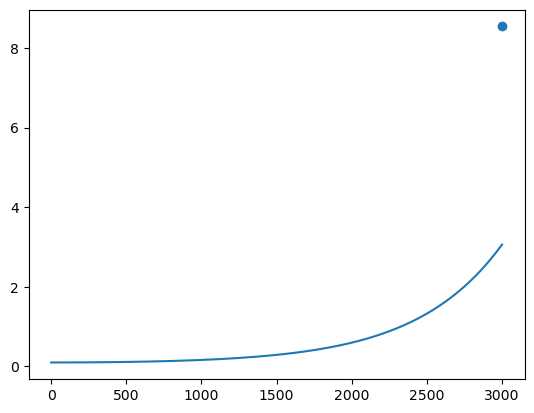

In [47]:
plt.plot(sol)
plt.scatter(3000,np.mean(u2s))

In [11]:
@njit
def vhats_proj(v, a, deg):
    N = len(v)
    vhat = np.zeros(N)
    for i in range(N):
        vi = v[i]
        for j in range(N):
            vj = v[j]
            if j <= len(a)-1:
                aj = a[j]
            else:
                aj = 0
            for k in range(deg):
                eijk = e_ijk(i,j,k)
                vhat[i] += 1/fact(k) (-0.5 * vi**2 + aj * vi) * eijk
    return vhat

def proj_hw(v,t,a,deg):
    vhats = vhats_proj(v,a,deg)
    return approx_book(t, vhats)

def proj_hw_min(v,a,deg,dt):
    vhats = vhats_proj(v,a,deg)

    diff = ((approx_book(1+dt,v)-approx_book(1,v)/dt)-approx_book(1,vhats))**2 + (approx_book(0,v)-0.1)**2
    return diff


# def new_odes_hw(v,t,a,deg):


In [12]:
from scipy.optimize import minimize

In [13]:
vhats_2 = minimize(proj_hw_min, np.array([0,0,0]), args= (np.array([0, 1]), 3, 0.1)).x

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of int64 with parameters (float64)
No type info available for int64 as a callable.
During: resolving callee type: int64
During: typing of call at /var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_18986/3912245448.py (15)


File "../../../../../../../../../var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_18986/3912245448.py", line 15:
<source missing, REPL/exec in use?>


In [ ]:
app_2 = approx_book(t, vhats_2)

NameError: name 'vhats_2' is not defined

In [ ]:
plt.plot(t, app_2)
plt.scatter(2*np.ones_like(dudt2s_mean), dudt2s_mean, marker='.', color = 'C1')

NameError: name 'app_2' is not defined

In [ ]:
from scipy.integrate import odeint
deg = 3
a = np.array([0.1,0,0])
b = get_b_book(deg, 0.1)
t_span = np.linspace(0,2,201)

# solve_ivp(proj_hw,[0,2],b,args=(a, deg))
sol = odeint(proj_hw, 0.1, t_span, args=(a, deg))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of int64 with parameters (float64)
No type info available for int64 as a callable.
During: resolving callee type: int64
During: typing of call at /var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_15414/3912245448.py (15)


File "../../../../../../../../../var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_15414/3912245448.py", line 15:
<source missing, REPL/exec in use?>


In [ ]:
plt.plot(t_span,sol)
plt.scatter(2*np.ones_like(dudt2s_mean), dudt2s_mean, marker='.', color = 'C1')

NameError: name 'sol' is not defined

In [59]:
4%2

0

In [63]:
from group_2.util import hermite_expectation
M = 3

for i in range(M):
    for j in range(M):
        for k in range(M):
            print(e_ijk(i,j,k))
            print(hermite_expectation(i,j,k))
            

1.0
1.0
0
0
0
0
0
0
1.0
1.0
0
0
0
0
0
0
2.0
2.0
0
0
1.0
1.0
0
0
1.0
1.0
0
0
2.0
2.0
0
0
2.0
2.0
0
0
0
0
0
0
2.0
2.0
0
0
2.0
2.0
0
0
2.0
2.0
0
0
8.0
8.0
